# Tomographic Measurements

Circuit

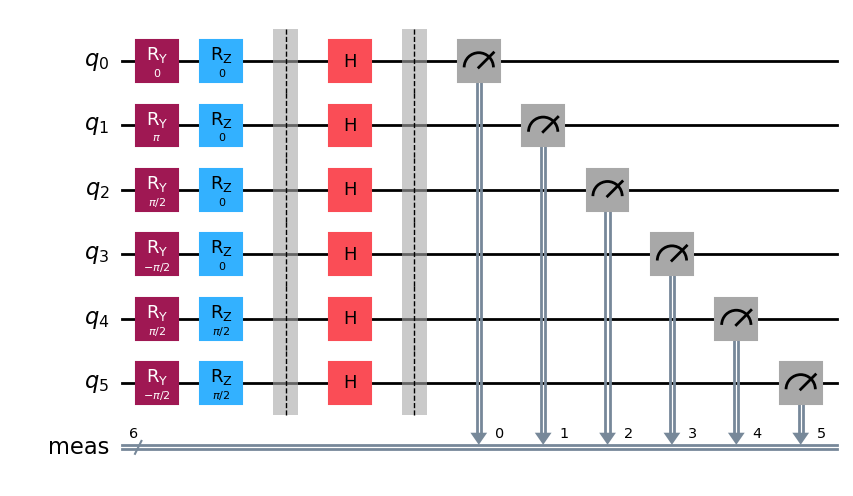

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.visualization import circuit_drawer
import numpy as np

# Define the reference states initialization
def initialize_reference_states(qc):
    # |0⟩ state on qubit 0
    qc.ry(0, 0)
    qc.rz(0, 0)

    # |1⟩ state on qubit 1
    qc.ry(np.pi, 1)
    qc.rz(0, 1)

    # |+⟩ state on qubit 2
    qc.ry(np.pi/2, 2)
    qc.rz(0, 2)

    # |−⟩ state on qubit 3
    qc.ry(-np.pi/2, 3)
    qc.rz(0, 3)

    # |+i⟩ state on qubit 4
    qc.ry(np.pi/2, 4)
    qc.rz(np.pi/2, 4)

    # |-i⟩ state on qubit 5
    qc.ry(-np.pi/2, 5)
    qc.rz(np.pi/2, 5)


# Create a 6-qubit quantum circuit
circuit = QuantumCircuit(6)

# Initialize the reference states
initialize_reference_states(circuit)

# Apply the same unitary to all 6 qubits
circuit.barrier()  # Add a barrier for clarity in the visualization
for qubit in range(6):
    circuit.h(qubit)

# Draw the circuit
circuit.measure_all()
circuit_drawer(circuit, output='mpl')


Collecting the tomographic measurements

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Define the reference circuits for each state
def create_reference_circuits_H():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Pauli-X variational circuit
theta = np.pi/2
phi = 0
Lambda = np.pi
variational_circuit_H = QuantumCircuit(1)
variational_circuit_H.rz(Lambda, 0)
variational_circuit_H.ry(theta, 0)
variational_circuit_H.rz(phi, 0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit_H, variational_circuit_H):
    combined_circuit = reference_circuit_H.compose(variational_circuit_H, inplace=False)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Function to produce measurements and put them in a matrix
def produce_measurements_pauli_H():
    measurements_matrix_H = []

    reference_circuits_H = create_reference_circuits_H()

    # Iterate over the reference circuits
    for reference_circuit_H in reference_circuits_H:
        # Combine the reference circuit with the Pauli-X gate circuit
        combined_circuit = combine_circuits(reference_circuit_H, variational_circuit_H)
        
        # Measure the combined circuit in each basis
        prob_z = get_probabilities(measure_circuit(combined_circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(combined_circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(combined_circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append measurements for the current reference circuit
        measurements_matrix_H.append(measured_probabilities)

    return np.array(measurements_matrix_H)

# Produce and print measurements for the Pauli-X circuit
measurements_matrix_H = produce_measurements_pauli_H()
print("Measurements matrix for Hadamard gate:")
print(measurements_matrix_H)


Measurements matrix for Hadamard gate:
[[0.5009 0.4991 1.     0.     0.5035 0.4965]
 [0.4954 0.5046 0.     1.     0.4962 0.5038]
 [1.     0.     0.4953 0.5047 0.4977 0.5023]
 [0.     1.     0.5011 0.4989 0.4934 0.5066]
 [0.5058 0.4942 0.5025 0.4975 0.     1.    ]
 [0.5074 0.4926 0.4952 0.5048 1.     0.    ]]


# Variational Circuit

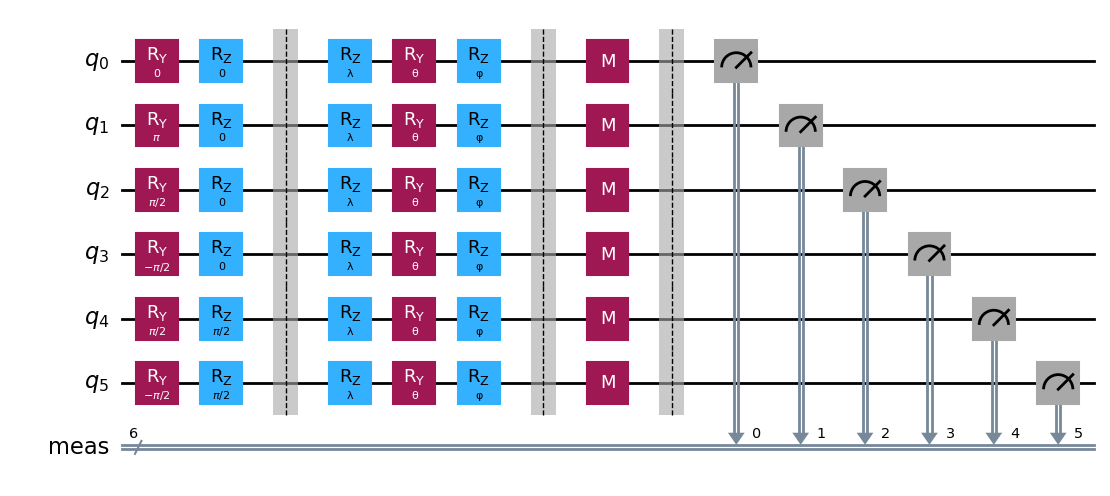

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, Gate
from qiskit.visualization import circuit_drawer
import numpy as np

# Define the reference states initialization
def initialize_reference_states(qc):
    # |0⟩ state on qubit 0
    qc.ry(0, 0)
    qc.rz(0, 0)

    # |1⟩ state on qubit 1
    qc.ry(np.pi, 1)
    qc.rz(0, 1)

    # |+⟩ state on qubit 2
    qc.ry(np.pi/2, 2)
    qc.rz(0, 2)

    # |−⟩ state on qubit 3
    qc.ry(-np.pi/2, 3)
    qc.rz(0, 3)

    # |+i⟩ state on qubit 4
    qc.ry(np.pi/2, 4)
    qc.rz(np.pi/2, 4)

    # |-i⟩ state on qubit 5
    qc.ry(-np.pi/2, 5)
    qc.rz(np.pi/2, 5)

# Define parameters for the unitary
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a 6-qubit quantum circuit
circuit = QuantumCircuit(6)

# Initialize the reference states
initialize_reference_states(circuit)

# Apply the same unitary to all 6 qubits
circuit.barrier()  # Add a barrier for clarity in the visualization
for qubit in range(6):
    circuit.rz(Lambda, qubit)
    circuit.ry(theta, qubit)
    circuit.rz(phi, qubit)

# Define the custom gate 'M'
# For demonstration, use an identity gate (you can replace this with your own gate implementation)
circuit.barrier()
def create_custom_gate():
    custom_gate = Gate('M', 1, [])
    return custom_gate

# Apply the custom gate 'M' to all qubits
custom_gate = create_custom_gate()
for qubit in range(6):
    circuit.append(custom_gate, [qubit])

# Draw the circuit
circuit.measure_all()

circuit_drawer(circuit, output='mpl')


# Cost function

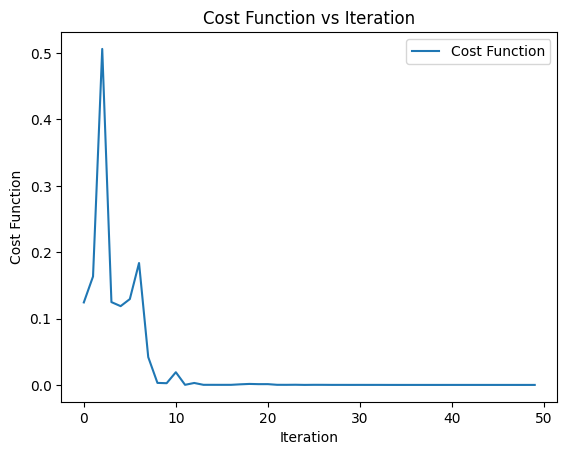

Optimal Parameters: [1.65505567 0.01495739 3.13568172]
Optimal Cost: 2.7338180000002546e-06


Optimal Parameters:
theta: 1.6550556708400486
phi: 0.014957387058292002
Lambda:3.1356817160932717


In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a variational circuit
variational_circuit = QuantumCircuit(1)
variational_circuit.rz(Lambda, 0)
variational_circuit.ry(theta, 0)
variational_circuit.rz(phi, 0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.z(0)
        circuit.x(0)
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.x(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit




# Cost function across all reference states
def cost_function(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits()

    #total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits(reference_circuit, variational_circuit, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost = cost

    if callback:
        callback(params, total_cost)

    return total_cost

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (4*np.pi/9)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  

def constraint_phi_upper(params):
    return np.pi/36 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (5*np.pi/6)

def constraint_lambda_upper(params):
    return np.pi - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},  
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower},  
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value
    #print(f"Parameters: {params}")
    #print(f"Cost: {cost}\n")

target_measurements_H = measurements_matrix_H
# Initial guess for parameters 
initial_params = [4*np.pi/9, np.pi/36, 5*np.pi/6]  

# Optimize parameters using COBYLA with constraints
result_H = minimize(
    cost_function, 
    initial_params, 
    args=(target_measurements_H, callback_function), 
    method='COBYLA', 
    #bounds = [(4*np.pi/9, np.pi/2) , (0, np.pi/36 ), (5*np.pi/6, np.pi)]
    constraints=constraints
)

# Plot the final cost vs iterations after optimization
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-Z operator')
plt.legend()
plt.savefig('1000 COBYLA_Z normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-Z operator')
plt.yscale('log')
plt.legend()
plt.savefig('1000 COBYLA_Z log_scale_cost_function_plot.png')
plt.close()

# Optimal parameters
optimal_params_H = result_H.x
optimal_cost_H = result_H.fun
print("Optimal Parameters:", optimal_params_H)
print("Optimal Cost:", optimal_cost_H)

print("\n\nOptimal Parameters:")
theta_opt_H, phi_opt_H, Lambda_opt_H = result_H.x
print(f"theta: {theta_opt_H}")
print(f"phi: {phi_opt_H}")
print(f"Lambda:{Lambda_opt_H}")


# Variational operator

In [11]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_H = rotation_matrix(theta_opt_H, phi_opt_H, Lambda_opt_H)

# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_H)


Unitary Matrix, U:
[[ 0.67669798+0.j          0.73624785-0.00435197j]
 [ 0.73617836+0.01101213j -0.67667029-0.00612163j]]


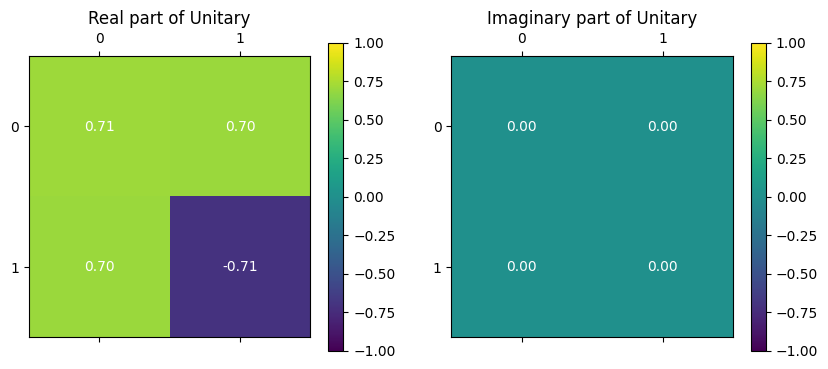

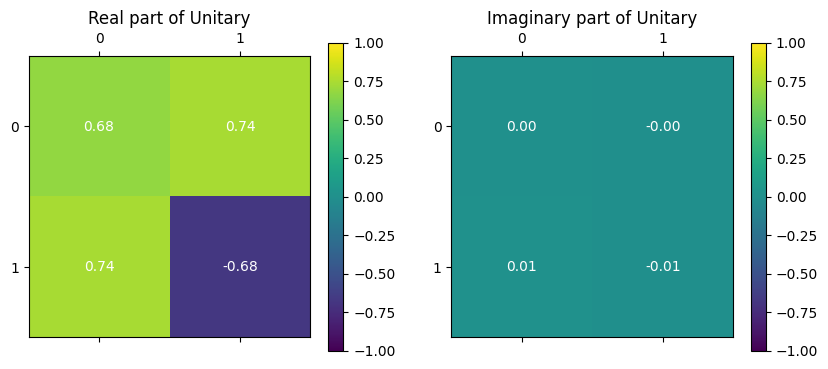

In [12]:
H = np.array([[np.sqrt(2)/2, 0.70], [0.70, -np.sqrt(2)/2]])
Unitary = np.array(rotation_matrix_result_H)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(H, 'Unitary', vmin=-1, vmax=1)
plot_matrix(Unitary, 'Unitary', vmin=-1, vmax=1)


# Measurements from the Variational Circuit

In [14]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_H, target_measurements_H)


Measured Probabilities for reference state 1: [0.541747, 0.458253, 0.998211, 0.001789, 0.50299, 0.49701]
Measured Probabilities for reference state 2: [0.458362, 0.541638, 0.001798, 0.998202, 0.496289, 0.503711]
Measured Probabilities for reference state 3: [0.998233, 0.001767, 0.457563, 0.542437, 0.492124, 0.507876]
Measured Probabilities for reference state 4: [0.0018, 0.9982, 0.541545, 0.458455, 0.507729, 0.492271]
Measured Probabilities for reference state 5: [0.492858, 0.507142, 0.503948, 0.496052, 6.6e-05, 0.999934]
Measured Probabilities for reference state 6: [0.507923, 0.492077, 0.496592, 0.503408, 0.999919, 8.1e-05]

Measured Probabilities Matrix:
[0.541747, 0.458253, 0.998211, 0.001789, 0.50299, 0.49701]
[0.458362, 0.541638, 0.001798, 0.998202, 0.496289, 0.503711]
[0.998233, 0.001767, 0.457563, 0.542437, 0.492124, 0.507876]
[0.0018, 0.9982, 0.541545, 0.458455, 0.507729, 0.492271]
[0.492858, 0.507142, 0.503948, 0.496052, 6.6e-05, 0.999934]
[0.507923, 0.492077, 0.496592, 0.503

In [15]:
# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_H)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

The Target Measurements 

[[0.5009 0.4991 1.     0.     0.5035 0.4965]
 [0.4954 0.5046 0.     1.     0.4962 0.5038]
 [1.     0.     0.4953 0.5047 0.4977 0.5023]
 [0.     1.     0.5011 0.4989 0.4934 0.5066]
 [0.5058 0.4942 0.5025 0.4975 0.     1.    ]
 [0.5074 0.4926 0.4952 0.5048 1.     0.    ]]


The Prepared Measurements 

[[5.41747e-01 4.58253e-01 9.98211e-01 1.78900e-03 5.02990e-01 4.97010e-01]
 [4.58362e-01 5.41638e-01 1.79800e-03 9.98202e-01 4.96289e-01 5.03711e-01]
 [9.98233e-01 1.76700e-03 4.57563e-01 5.42437e-01 4.92124e-01 5.07876e-01]
 [1.80000e-03 9.98200e-01 5.41545e-01 4.58455e-01 5.07729e-01 4.92271e-01]
 [4.92858e-01 5.07142e-01 5.03948e-01 4.96052e-01 6.60000e-05 9.99934e-01]
 [5.07923e-01 4.92077e-01 4.96592e-01 5.03408e-01 9.99919e-01 8.10000e-05]]


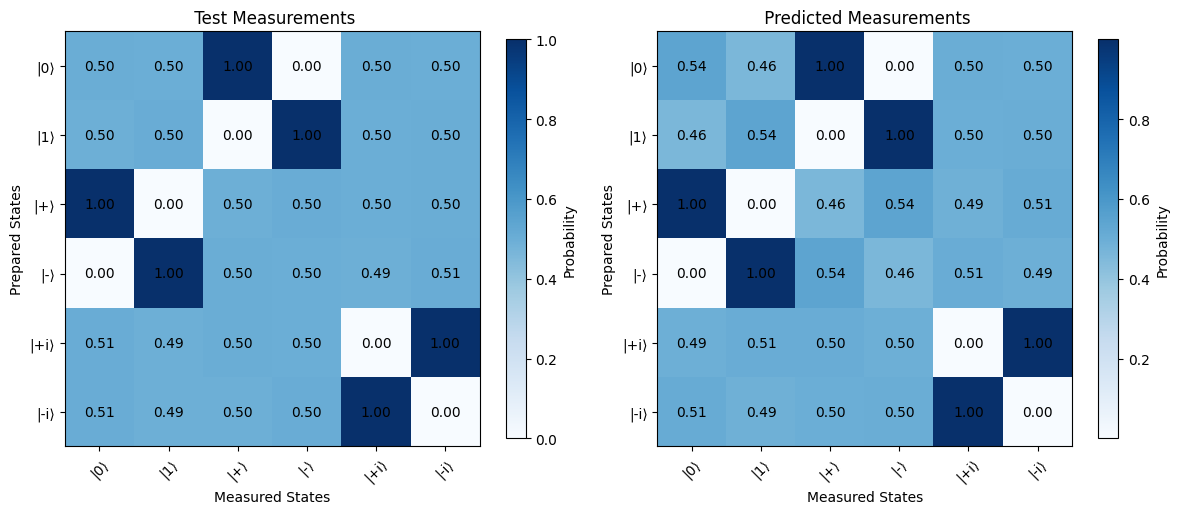

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurements')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink=0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()